In [1]:
from googleapiclient.discovery import build
import pandas as pd
import numpy as np

from IPython.display import JSON
from dateutil import parser

# Data viz packages
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\19054\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\19054\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
api_key = 'XXX'

user_names = ['GoogleDevelopers', ]

api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "YOUR_CLIENT_SECRET_FILE.json"

# Get credentials and create an API client

youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [3]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        forUsername=','.join(user_names)
    )
    response = request.execute()
    
    # loop through items
    for item in response['items']:
        data = {
            'channelName' : item['snippet']['title'],
            'subscribers' : item['statistics']['subscriberCount'],
            'views' : item['statistics']['viewCount'],
            'totalViews' : item['statistics']['videoCount'],
            'playlistId' : item['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)
    return (pd.DataFrame(all_data))

In [4]:
channel_stats = get_channel_stats(youtube, user_names)

In [5]:
channel_stats

,channelName,subscribers,views,totalViews,playlistId
0,Google for Developers,2310000,235069631,5834,UU_x5XG1OV2P6uZZ5FSM9Ttw


In [6]:
playlist_id = "UU_x5XG1OV2P6uZZ5FSM9Ttw"

def get_video_ids(youtube, playlist_id):
    video_ids = []
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        maxResults=50,
        playlistId=playlist_id
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part = 'contentDetails',
            playlistId = playlist_id,
            maxResults = 50,
            pageToken = next_page_token)
        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [7]:
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

5834

In [8]:
def get_video_details(youtube, video_ids):
    all_video_info = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {
                'snippet' : ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                'statistics' : ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                'contentDetails' : ['duration', 'definition', 'caption']
            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None
            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [9]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,mDwwrdnT1-I,Google for Developers,Puf’s career tips,Ever wondered how Puf kickstarted his journey ...,"[Google, developers]",2023-09-08T04:00:32Z,4039,174,None,6,PT54S,hd,true
1,sx3DsYEMMH8,Google for Developers,Aliens or Ghosts?,Aliens or ghosts? We asked some devs at Google...,"[Google, developers, Developer, Google for dev...",2023-09-07T16:00:39Z,2848,36,None,44,PT52S,hd,false
2,qBS8FSnS0p4,Google for Developers,Deep space or the ocean?,Devs have the choice between adventuring into ...,"[Google, developers, Developer, Google for dev...",2023-09-06T20:00:15Z,2780,58,None,5,PT52S,hd,true
3,NlHnIXzKJX4,Google for Developers,Coding in light mode = 🚩,How do people even code in light mode? \n\nSub...,"[Google, developers]",2023-09-06T13:00:26Z,5921,128,None,13,PT9S,hd,true
4,vK4CaT-0C1g,Google for Developers,Vertex AI Next 2023 Announcements,TL;DR 357 | The Google Developer News Show\n\...,"[Google, developers, the Developer Show, TLDR,...",2023-09-06T03:00:34Z,3612,92,None,3,PT52S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,5Eib_H_zCEY,Google for Developers,Cluster Computing and MapReduce Lecture 3,Lecture 3: The Google File System. See\r\nhttp...,"[gcvtechtalk, mapreduce, gfs, hadoop, cluster,...",2007-08-28T16:56:29Z,65126,216,None,8,PT44M41S,sd,false
5830,yjPBkvYh-ss,Google for Developers,Cluster Computing and MapReduce Lecture 1,Lecture 1 in a five part series introducing ma...,"[gcvtechtalk, mapreduce, gfs, hadoop, cluster,...",2007-08-28T16:53:57Z,228816,876,None,54,PT46M17S,sd,false
5831,-vD6PUdf3Js,Google for Developers,Cluster Computing and MapReduce Lecture 2,Lecture 2: The MapReduce programming model. Se...,"[gcvtechtalk, mapreduce, gfs, hadoop, cluster,...",2007-08-28T16:51:42Z,104132,313,None,34,PT52M6S,sd,false
5832,1ZDybXl212Q,Google for Developers,Cluster Computing and MapReduce Lecture 4,Lecture 4: Clustering Algorithms with MapReduc...,"[gcvtechtalk, mapreduce, gfs, hadoop, cluster,...",2007-08-28T16:46:15Z,123166,240,None,39,PT23M31S,sd,false


In [10]:
# def get_comments_in_videos(youtube, video_ids):
#     all_comments = []
    
#     for video_id in video_ids:
#         request = youtube.commentThreads().list(
#             part = "snippet, replies",
#             videoId = video_id
#         )
#         response = request.execute()
        
#         comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
#         comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}
        
#         all_comments.append(comments_in_video_info)
        
#     return pd.DataFrame(all_comments)

# comments_df = get_comments_in_videos(youtube, video_ids)
# comments_df

## Data Pre-processing

In [11]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount          True
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [12]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [13]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [14]:
# Publish day in a week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [15]:
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,54.0,PT54S
1,52.0,PT52S
2,52.0,PT52S
3,9.0,PT9S
4,52.0,PT52S
...,...,...
5829,2681.0,PT44M41S
5830,2777.0,PT46M17S
5831,3126.0,PT52M6S
5832,1411.0,PT23M31S


In [16]:
# add number tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x : 0 if x is None else len(x))

In [17]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagsCount
0,mDwwrdnT1-I,Google for Developers,Puf’s career tips,Ever wondered how Puf kickstarted his journey ...,"[Google, developers]",2023-09-08 04:00:32+00:00,4039.0,174.0,NaN,6.0,PT54S,hd,true,Friday,54.0,2
1,sx3DsYEMMH8,Google for Developers,Aliens or Ghosts?,Aliens or ghosts? We asked some devs at Google...,"[Google, developers, Developer, Google for dev...",2023-09-07 16:00:39+00:00,2848.0,36.0,NaN,44.0,PT52S,hd,false,Thursday,52.0,8
2,qBS8FSnS0p4,Google for Developers,Deep space or the ocean?,Devs have the choice between adventuring into ...,"[Google, developers, Developer, Google for dev...",2023-09-06 20:00:15+00:00,2780.0,58.0,NaN,5.0,PT52S,hd,true,Wednesday,52.0,8
3,NlHnIXzKJX4,Google for Developers,Coding in light mode = 🚩,How do people even code in light mode? \n\nSub...,"[Google, developers]",2023-09-06 13:00:26+00:00,5921.0,128.0,NaN,13.0,PT9S,hd,true,Wednesday,9.0,2
4,vK4CaT-0C1g,Google for Developers,Vertex AI Next 2023 Announcements,TL;DR 357 | The Google Developer News Show\n\...,"[Google, developers, the Developer Show, TLDR,...",2023-09-06 03:00:34+00:00,3612.0,92.0,NaN,3.0,PT52S,hd,true,Wednesday,52.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,5Eib_H_zCEY,Google for Developers,Cluster Computing and MapReduce Lecture 3,Lecture 3: The Google File System. See\r\nhttp...,"[gcvtechtalk, mapreduce, gfs, hadoop, cluster,...",2007-08-28 16:56:29+00:00,65126.0,216.0,NaN,8.0,PT44M41S,sd,false,Tuesday,2681.0,10
5830,yjPBkvYh-ss,Google for Developers,Cluster Computing and MapReduce Lecture 1,Lecture 1 in a five part series introducing ma...,"[gcvtechtalk, mapreduce, gfs, hadoop, cluster,...",2007-08-28 16:53:57+00:00,228816.0,876.0,NaN,54.0,PT46M17S,sd,false,Tuesday,2777.0,10
5831,-vD6PUdf3Js,Google for Developers,Cluster Computing and MapReduce Lecture 2,Lecture 2: The MapReduce programming model. Se...,"[gcvtechtalk, mapreduce, gfs, hadoop, cluster,...",2007-08-28 16:51:42+00:00,104132.0,313.0,NaN,34.0,PT52M6S,sd,false,Tuesday,3126.0,10
5832,1ZDybXl212Q,Google for Developers,Cluster Computing and MapReduce Lecture 4,Lecture 4: Clustering Algorithms with MapReduc...,"[gcvtechtalk, mapreduce, gfs, hadoop, cluster,...",2007-08-28 16:46:15+00:00,123166.0,240.0,NaN,39.0,PT23M31S,sd,false,Tuesday,1411.0,10


## EDA

### Best Performing Videos

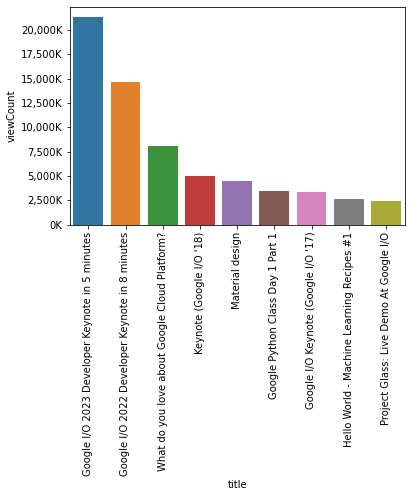

In [18]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

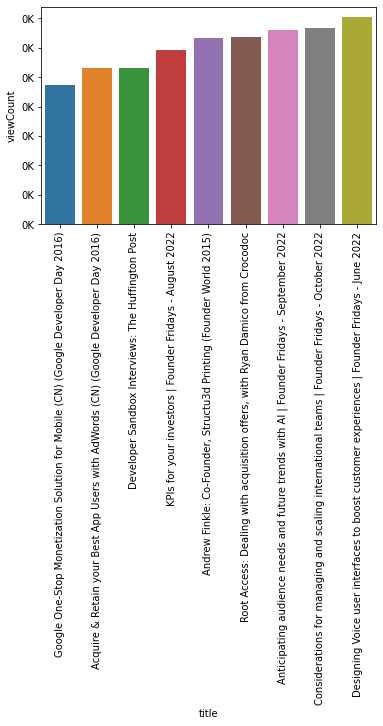

In [19]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### View Distribution per video

C:\Users\19054\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

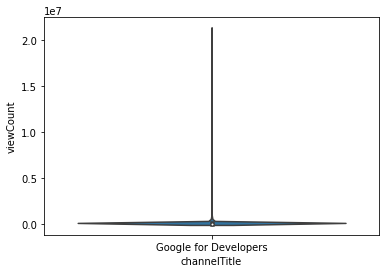

In [20]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

### Views vs Likes and Comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

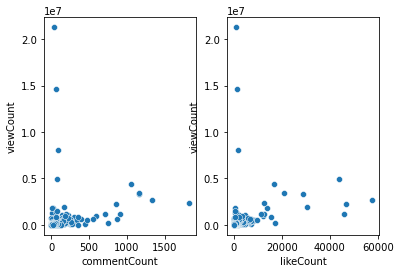

In [21]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

### Video Duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

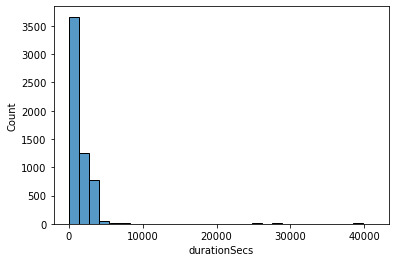

In [22]:
sns.histplot(data = video_df, x = 'durationSecs', bins = 30)

### Wordcloud for Video Titles

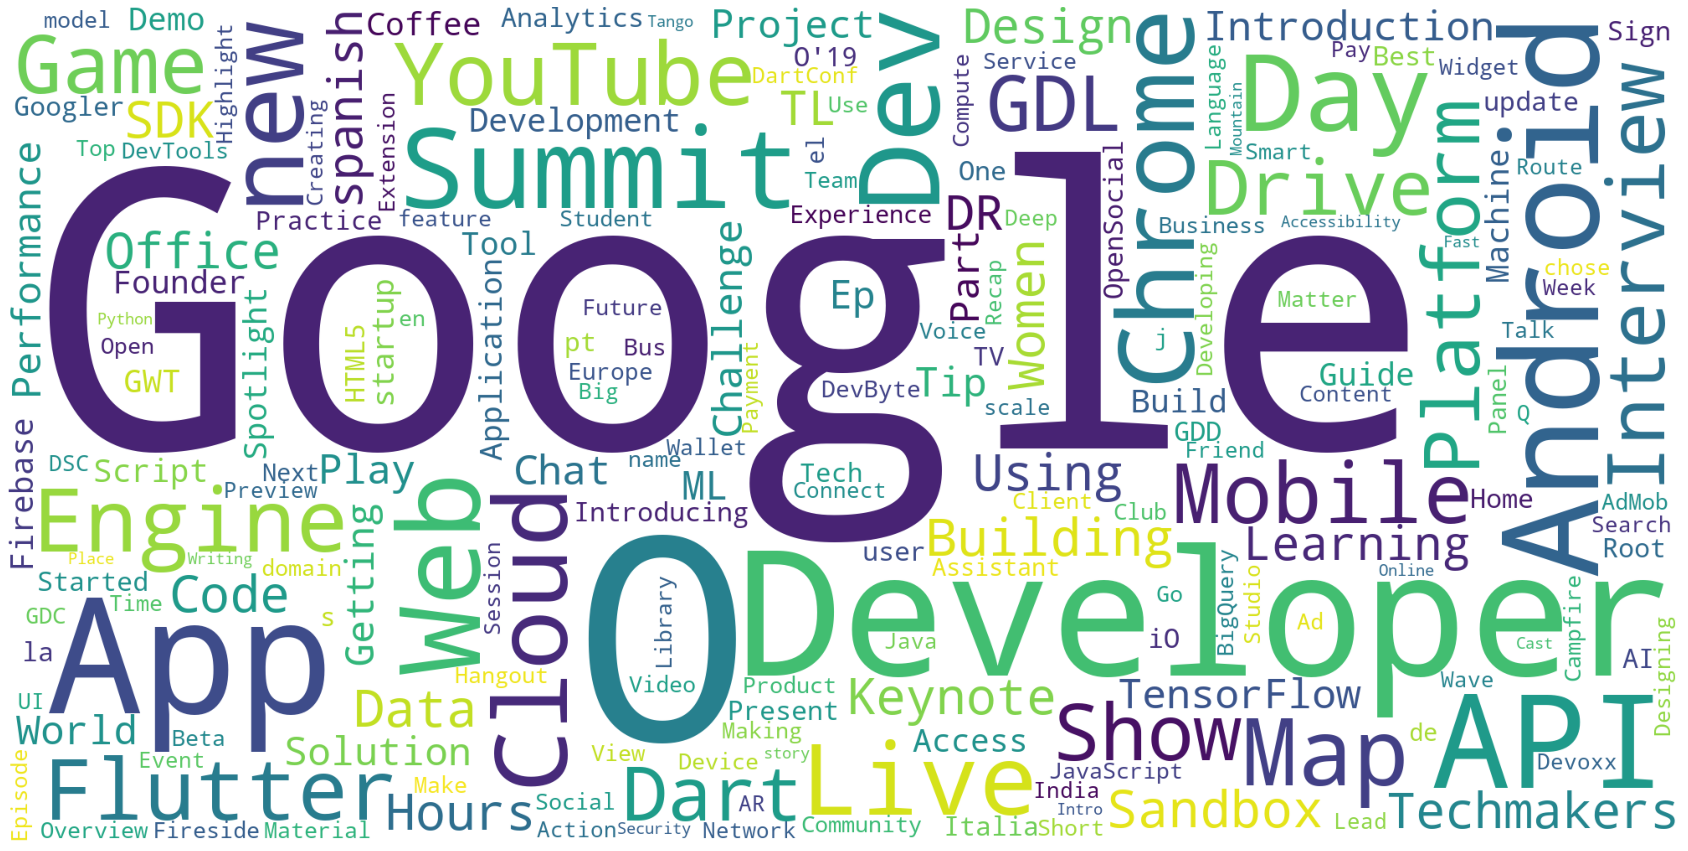

In [23]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize = (30, 20))
    plt.imshow(wordcloud)
    plt.axis("off")

wordcloud = WordCloud(width = 2000, height = 1000, random_state = 1, background_color = 'white',
                     colormap = 'viridis', collocations = False).generate(all_words_str)

plot_cloud(wordcloud)

### Upload Schedule

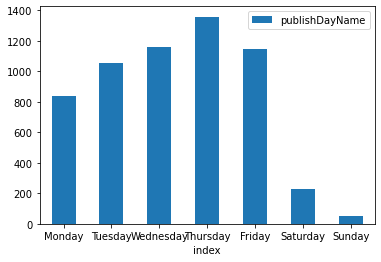

In [24]:
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x = 'index', y = 'publishDayName', rot = 0)